In [31]:
import credentials # Api key is stored in this file, remove to avoid errors if you clone from github

import pvdeg
import pvlib
from numba import njit, vectorize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.linalg import cholesky
from scipy import stats

First get weather data and metadata for a desired location (latitude and logitude)

In [3]:
# change to desired values (currently Miami)
latitude = 25.783388
longitude = -80.189029

API_KEY = credentials.API_KEY # my personal NREL api key
email ='tobin.ford@nrel.gov' # replace these values with your appropriate information and remove and comment out first line of first block (import credentials)

# reads NSRDB data 
weather_df, meta = pvlib.iotools.get_psm3(latitude, longitude, API_KEY, email, names='2019', map_variables=True)

c:\ProgramData\anaconda3\envs\monte-carlo\lib\site-packages\pvlib\iotools\psm3.py:183: pvlibDeprecationWarning: The ``get_psm3`` function will default to leap_day=True starting in pvlib 0.11.0. Specify leap_day=True to enable this behavior now, or specify leap_day=False to hide this warning.
  warnings.warn(


User has 3 parameters for initial implementation: See Kempe's "Deg Miami" tab in excel<br>



activation energy, Ea <br>
irradiance relation, x<br>
ln(R0)<br>

|           |   Ea   |   x   | ln(R0) |
|:---------:|:-----:|:----:|:-------:|
|   **Ea**  |   1   |   a  |   b     |
|   **x**   |   a   |   1  |   c     |
| **ln(R0)**|   b   |   c  |   1     |

Notice symmetry across diagonal <br>

In [4]:
# USER ENTERED VALUES
# Correlation Coefficients
Ea_X = 0.0269
Ea_lnR0 = -0.9995 
X_lnR0 = -0.0400

# Activation Energy
mean_Ea = 62.08 # average
sd_Ea = 7.3858 # standard deviation

# Irradiance relation
mean_X = 0.0341 # average
sd_X = 0.0992757 # standard deviation

# ln(R0)
mean_lnR0 = 13.7223084 
sd_lnR0 = 2.47334772

# number of iterations
n = 20000

In [5]:
# notice symmetry of matrix
A = np.array([[1,   Ea_X,   Ea_lnR0],
              [Ea_X,    1,   X_lnR0],
              [Ea_lnR0, X_lnR0,   1]])

# conceptually similar to the square root of a matrix
A_decomp = cholesky(A, lower=True) 

# now: creates random distribution with mean = 0 and std = 1 for n points
ea = np.random.normal(loc=0, scale=1, size=n)
x = np.random.normal(loc=0, scale=1, size=n)
lnR0 = np.random.normal(loc=0, scale=1, size=n)


# create a numPy array to use in operations later
# somewhat misleadingly named a matrix instead of an array
samples_matrix = np.array([ea, x, lnR0])


In [6]:
# correlated stats pre-input to function using MonteCarloEaLnRoX
correlated_samples = np.matmul(A_decomp, samples_matrix)

sol_pos = pvdeg.spectral.solar_position(weather_df, meta)
poa_irradiance = pvdeg.spectral.poa_irradiance(weather_df, meta)
temp_mod = pvdeg.temperature.module(weather_df=weather_df, meta=meta, poa=poa_irradiance, conf='open_rack_glass_polymer')

In [7]:
# correlates random values with cholesky decomposition
temp = np.matrix(np.matmul(A_decomp, samples_matrix))

# random samples * standard deviation + mean 
sd_mat = np.matrix([sd_Ea, sd_X, sd_lnR0]) 
sd_mat_transpose = np.transpose(sd_mat)
result = np.multiply(temp, sd_mat_transpose) + np.transpose(np.matrix([mean_Ea, mean_X, mean_lnR0]))

correlated_df = pd.DataFrame(np.transpose(result), columns=['ea', 'x', 'lnR0'])

In [8]:
# dummy check for mean and standard deviation
print(result[0].mean())
print(result[0].std())
print()
print(result[1].mean())
print(result[1].std())
print()
print(result[2].mean())
print(result[2].std())
print()

print("EA_X:", np.corrcoef(result[0], result[1]))
print("Ea_lnR0:", np.corrcoef(result[0], result[2]))
print("X_lnR0:", np.corrcoef(result[1], result[2]))

62.12343997274828
7.386468711969557

0.03417783119338063
0.09928912762322963

13.708328447052256
2.4734076937222067

EA_X: [[1.         0.03174901]
 [0.03174901 1.        ]]
Ea_lnR0: [[ 1.         -0.99950019]
 [-0.99950019  1.        ]]
X_lnR0: [[ 1.         -0.04490943]
 [-0.04490943  1.        ]]


In [26]:
# Kempe's function ported from excel
@njit
def forArrenius(poa_global, module_temp, ea, x, lnR0): # add type hinting
    degredation = np.zeros_like(ea) # matches the number of samples in ea

    # removing irradiance under 25 to avoid overflow errors, need to drop the corresponding index of module_temp
    mask = poa_global >= 25

    # drop elements
    poa_global = poa_global[mask]
    module_temp = module_temp[mask]
    weather = len(poa_global) # length of updated array

    # moved precalculations outside of loop, much faster this way
    ea1 = ea / 8.31446261815324E-03
    R0 = np.exp(lnR0)
    poa_global_scaled = poa_global / 1000

    for i in range(n):
        for j in range(weather):
            # very inefficient, an element-wise approach would be siginficantly faster
            degredation[i] += R0[i] * np.exp(-ea1[i] / (273.15 + module_temp[j])) * np.power(poa_global_scaled[j], x[i])

    return (degredation / 8760)

In [27]:
# list comprehension implementation of forArrehnius, still slow
@njit
def listArrhenius(poa_global, module_temp, ea, x, lnR0):
    degredation = np.zeros_like(ea)

    mask = poa_global >= 25
    poa_global = poa_global[mask]
    module_temp = module_temp[mask]

    ea1 = ea / 8.31446261815324E-03
    R0 = np.exp(lnR0)
    poa_global_scaled = poa_global / 1000

    degredation = [(z * np.exp(-x / (273.15 + module_temp)) * np.power(poa_global_scaled, y)).mean() for x, y, z in zip(ea1, x, R0)]
    
    return degredation

In [ ]:
# vectorized approach
# how to implement this
# we have arrays of 
@vectorize
def vecArrhenius(degredation, poa_global, module_temp, ea, x, lnR0): # not sure about doing it this way
    
    mask = poa_global >= 25
    poa_global = poa_global[mask]
    module_temp = module_temp[mask]

    for i in poa_global:
        degredation = 

In [28]:
# there must be a better way to pass these arugments
for_deg = forArrenius(poa_global=poa_irradiance['poa_global'].to_numpy(), 
                      module_temp=temp_mod.to_numpy(), 
                      ea=correlated_df['ea'].to_numpy(), 
                      x=correlated_df['x'].to_numpy(), 
                      lnR0=correlated_df['lnR0'].to_numpy())

list_deg = listArrhenius(poa_global=poa_irradiance['poa_global'].to_numpy(), 
                         module_temp=temp_mod.to_numpy(), 
                         ea=correlated_df['ea'].to_numpy(), 
                         x=correlated_df['x'].to_numpy(), 
                         lnR0=correlated_df['lnR0'].to_numpy())

In [ ]:
vec_deg = vecArrhenius(degredation=np.zeros_like(ea),
                        poa_global=poa_irradiance['poa_global'].to_numpy(), 
                        module_temp=temp_mod.to_numpy(), 
                        ea=correlated_df['ea'].to_numpy(), 
                        x=correlated_df['x'].to_numpy(), 
                        lnR0=correlated_df['lnR0'].to_numpy())

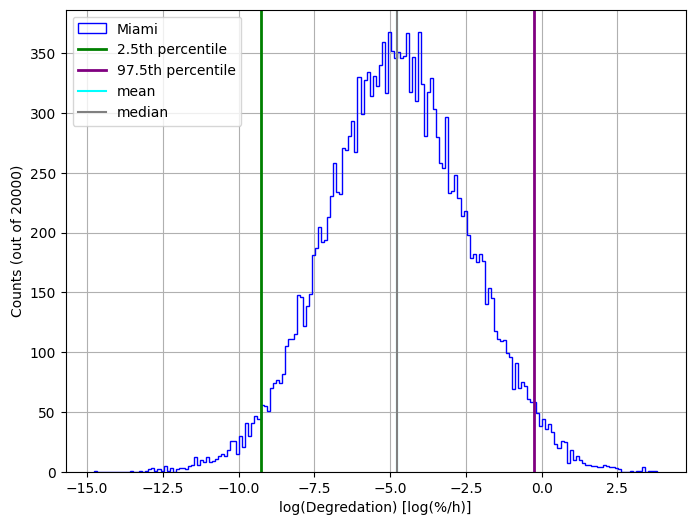

In [29]:
lnDeg = np.log10(for_deg)
percentile_2p5 = np.percentile(lnDeg, 2.5)
percentile_97p5 = np.percentile(lnDeg, 97.5)
bin_edges = np.arange(lnDeg.min(), lnDeg.max() + 0.1, 0.1)

plt.figure(figsize=(8,6))
plt.hist(lnDeg, bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Miami')

plt.axvline(percentile_2p5, color='green', label='2.5th percentile', linewidth=2.0)
plt.axvline(percentile_97p5, color='purple', label='97.5th percentile', linewidth=2.0)
plt.axvline(np.mean(lnDeg), color = 'cyan', label = 'mean' )
plt.axvline(np.median(lnDeg), color = 'gray', label = 'median')
plt.xlabel('log(Degredation) [log(%/h)]')
plt.ylabel(f'Counts (out of {n})')

plt.legend()
plt.grid(True)
plt.show()

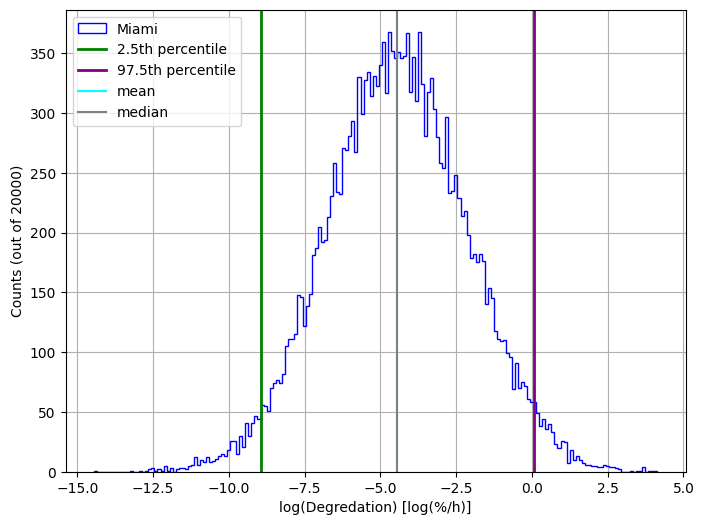

In [30]:
lnDeg = np.log10(list_deg) # excel does base 10 by default

percentile_2p5 = np.percentile(lnDeg, 2.5)
percentile_97p5 = np.percentile(lnDeg, 97.5)
bin_edges = np.arange(lnDeg.min(), lnDeg.max() + 0.1, 0.1)

plt.figure(figsize=(8,6))
plt.hist(lnDeg, bins=bin_edges, edgecolor='blue', histtype='step', linewidth=1, label = 'Miami')

plt.axvline(percentile_2p5, color='green', label='2.5th percentile', linewidth=2.0)
plt.axvline(percentile_97p5, color='purple', label='97.5th percentile', linewidth=2.0)
plt.axvline(np.mean(lnDeg), color = 'cyan', label = 'mean' )
plt.axvline(np.median(lnDeg), color = 'gray', label = 'median')
plt.xlabel('log(Degredation) [log(%/h)]')
plt.ylabel(f'Counts (out of {n})')

plt.legend()
plt.grid(True)
plt.show()

In [15]:
output_df = pd.DataFrame(for_deg)

print(output_df.head(20))

inf_values = output_df.isin([np.inf]).any(axis=1)
num_rows_with_inf = inf_values.sum()
print(num_rows_with_inf / n * 100, "% of rows have inf")

               0
0   2.249151e-07
1   1.459632e-06
2   1.463332e-05
3   3.678568e-08
4   4.267912e-05
5   4.229415e-04
6   1.049254e-03
7   3.104507e-06
8   3.432577e-03
9   2.798287e-05
10  3.282553e-04
11  9.354390e-09
12  1.901562e-04
13  6.684129e-11
14  2.311125e-02
15  1.069096e-04
16  1.913009e-03
17  8.554788e-05
18  4.376862e-02
19  3.677808e-04
0.0 % of rows have inf
